In [1]:
%matplotlib inline

In [2]:
from scipy import signal
from kid_readout.roach import demodulator

In [3]:
demod11 = demodulator.Demodulator(nfft=2**11, num_taps=8, window=signal.hamming, hardware_delay_samples=0)
demod14 = demodulator.Demodulator(nfft=2**14, num_taps=2, window=signal.flattop, hardware_delay_samples=0)

In [4]:
def window(n_nyquist, n, S, demod):
    n_window = 2 * n_nyquist * demod._window_frequency
    return S * np.interp(n, n_window, demod._window_response)**2
    

def alias(n_nyquist, n, S, combine=np.sum):
    bins, n_wrapped = divmod(n + n_nyquist, 2 * n_nyquist)
    n_aliased = n_wrapped - n_nyquist
    n_unique = np.arange(-n_nyquist, n_nyquist)
    S_combined = np.array([combine(S[n_aliased==u]) for u in n_unique])
    return n_aliased, bins, n_unique, S_combined


def normalize(n_nyquist, n_center, S, demod):
    n_window = 2 * n_nyquist * demod._window_frequency
    return S / np.interp(n_center, n_window, demod._window_response)**2


def demodulate(n_center, S, waveform_normalization=1):
    return waveform_normalization**2 * np.roll(S, -n_center)


def wand(n_nyquist, n_center, n, S, demod, waveform_normalization=1):
    S_w = window(n_nyquist=n_nyquist, n=n, S=S, demod=demod)
    n_aliased, bins, n_unique, S_wa = alias(n_nyquist=n_nyquist, n=n, S=S_w)
    S_wan = normalize(n_nyquist=n_nyquist, n_center=n_center, S=S_wa, demod=demod)
    S_wand = demodulate(n_center=n_center, S=S_wan, waveform_normalization=waveform_normalization)
    return n_aliased, bins, n_unique, S_wand

    
def double_to_single(n, S):
    return n[n.size // 2:], S[S.size // 2:] + S[:S.size // 2][::-1]


def spectrum(f, f_center, f_res=1, f_qp=1, A=0, QP=0, TLS1Hz=0, alpha_TLS=1/2):
    r_response = 1 / (1 + ((f - f_center) / f_res)**2)
    qp_response = 1 / (1 + ((f - f_center) / f_qp)**2)
    S_amp = A * np.ones(f.size)
    S_TLS = r_response * TLS1Hz * (np.abs(f - f_center) / 1)**-alpha_TLS
    S_qp = r_response * qp_response * QP
    return S_amp + S_TLS + S_qp

def readout(S, n_center, n_nyquist, sample_rate, demod):
    n_to_f = sample_rate / (2 * n_nyquist)
    n = np.arange(-S.size // 2, S.size // 2)
    S_w = window(n_nyquist=n_nyquist, n=n, S=S, demod=demod)
    n_aliased, bins, n_unique, S_wa = alias(n_nyquist=n_nyquist, n=n, S=S_w)
    S_wad = demodulate(n_center, S_wa)
    n1_original, S1_original = double_to_single(n, demodulate(n_center, S))
    n1_wad, S1_wad = double_to_single(n_unique, S_wad)
    return n_to_f * n1_original, S1_original, n_to_f * n1_wad, S1_wad

def readout_14(S, n_center, n_nyquist):
    return readout(S=S, n_center=n_center, n_nyquist=n_nyquist, sample_rate=512e6 / 2**14, demod=demod14)

def readout_11(S, n_center, n_nyquist):
    return readout(S=S, n_center=n_center, n_nyquist=n_nyquist, sample_rate=512e6 / 2**11, demod=demod11)

In [5]:
x_color = 'blue'
y_color = 'green'
xy_color = 'black'
in_linestyle = ':'
out_linestyle = '-'

In [6]:
# Select readout options
num_filterbank_channels = 2**14
sample_rate = 512e6 / num_filterbank_channels
1e-3 * sample_rate

31.25

In [7]:
# Create data arrays

# The number of frequency points in the double-sided output spectrum
num_frequencies_out = 2**14
n_nyquist = num_frequencies_out // 2

# This number converts integer index to frequency
n_to_f = sample_rate / num_frequencies_out

# The number of double-sided bandwidths to use for the aliasing calculation
num_bandwidths = 5

# The center frequency of the spectrum divided by the sample rate: the bin edges are +/- 0.5
center_normalized = 0.5

# The integer index of the center frequency
n_center = np.int(np.round(center_normalized * num_frequencies_out))

# The integer indices, each corresponding to a baseband frequency
n = np.arange(-num_bandwidths * num_frequencies_out // 2, num_bandwidths * num_frequencies_out // 2)

In [8]:
f_res = 2e3
f_qp = 3e3
A = 1e-19
S2_xx = spectrum(f=n * n_to_f, f_center=n_center * n_to_f, f_res=f_res, f_qp=f_qp, A=A, QP=1e-19, TLS1Hz=3e-18)
S2_yy = spectrum(f=n * n_to_f, f_center=n_center * n_to_f, f_res=f_res, f_qp=f_qp, A=A, QP=0, TLS1Hz=0)
f1_in, S1_xx_in, f1_out, S1_xx_out = readout_14(S=S2_xx, n_center=n_center, n_nyquist=num_frequencies_out // 2)
_, S1_yy_in, _, S1_yy_out = readout_14(S=S2_yy, n_center=n_center, n_nyquist=num_frequencies_out // 2)

/home/flanigan/miniconda2/envs/analysis/lib/python2.7/site-packages/ipykernel/__main__.py:39: RuntimeWarning: divide by zero encountered in power
/home/flanigan/miniconda2/envs/analysis/lib/python2.7/site-packages/ipykernel/__main__.py:39: RuntimeWarning: invalid value encountered in multiply


/home/flanigan/miniconda2/envs/analysis/lib/python2.7/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


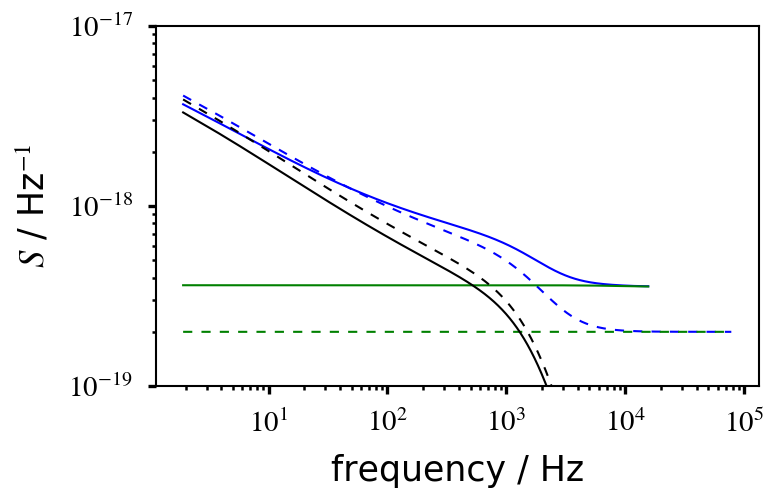

In [9]:
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('frequency / Hz')
ax.set_ylabel('$S$ / Hz$^{-1}$')
ax.plot(f1_in, S1_xx_in, color=x_color, linestyle=in_linestyle)
ax.plot(f1_out, S1_xx_out, color=x_color, linestyle=out_linestyle)
ax.plot(f1_in, S1_yy_in, color=y_color, linestyle=in_linestyle)
ax.plot(f1_out, S1_yy_out, color=y_color, linestyle=out_linestyle)
ax.plot(f1_in, S1_xx_in - S1_yy_in, color=xy_color, linestyle=in_linestyle)
ax.plot(f1_out, S1_xx_out - S1_yy_out, color=xy_color, linestyle=out_linestyle)
ax.set_ylim(1e-19, 1e-17);

# Old code with more plots

In [10]:
# The spectrum of the PFB output at baseband
#S = spectrum(f=n * n_to_f, f_center=n_center * n_to_f, f_res=25e3, f_qp=3e3, A=1e-20, QP=0, TLS1Hz=1e-19)
S = spectrum(f=n * n_to_f, f_center=n_center * n_to_f, f_res=3e3, f_qp=4e3, A=1e-19, QP=2e-19, TLS1Hz=3e-18)

/home/flanigan/miniconda2/envs/analysis/lib/python2.7/site-packages/ipykernel/__main__.py:39: RuntimeWarning: divide by zero encountered in power


In [11]:
# Simulate the effect of the readout on the spectrum
S_w = window(n_nyquist=n_nyquist, n=n, S=S, demod=demod14)
n_aliased, bins, n_unique, S_wa = alias(n_nyquist=n_nyquist, n=n, S=S_w)
#S_wan = normalize(n_nyquist=n_nyquist, n_center=n_center, S=S_wa, demod=demod)
S_wad = demodulate(n_center, S_wa)

n1, S1  = double_to_single(n, demodulate(n_center, S))
n1_wad, S1_wad = double_to_single(n_unique, S_wad)

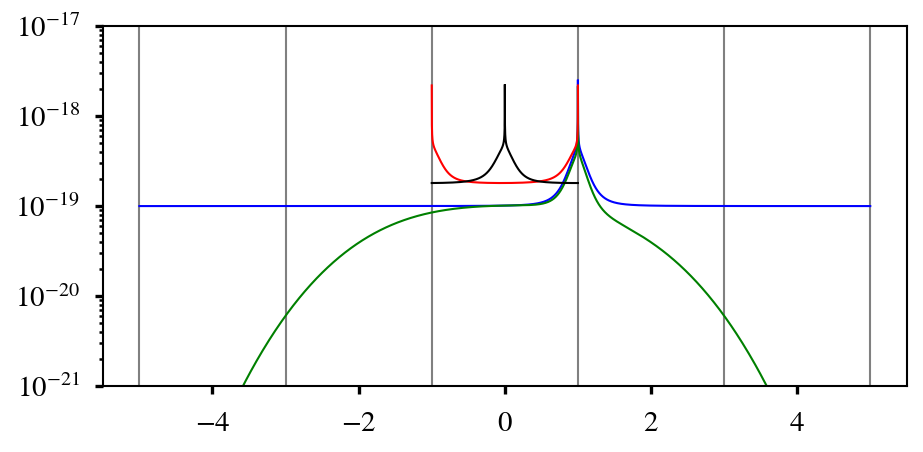

In [12]:
fig, ax = plt.subplots(figsize=(4, 2))
ax.set_yscale('log')
for b in np.arange(-np.floor(num_bandwidths), np.ceil(num_bandwidths) + 1, 2):
    ax.axvline(b, color='gray')
ax.plot(n / n_nyquist, S, '-b')
ax.plot(n / n_nyquist, S_w, '-g')
ax.plot(n_unique / n_nyquist, S_wa, '-r')
ax.plot(n_unique / n_nyquist, S_wad, '-k')
ax.set_ylim(1e-21, 1e-17);

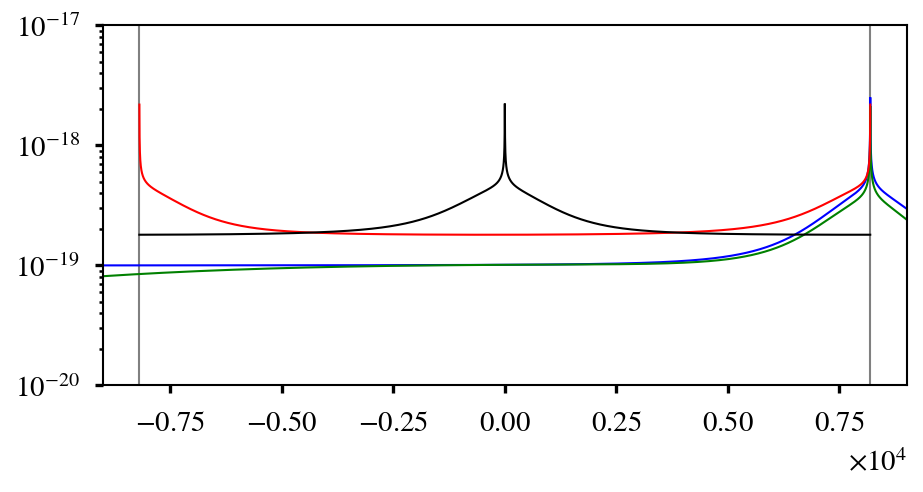

In [13]:
fig, ax = plt.subplots(figsize=(4, 2))
ax.set_yscale('log')
for b in np.arange(-np.floor(num_bandwidths), np.ceil(num_bandwidths) + 1, 2):
    ax.axvline(b * n_nyquist, color='gray')
ax.plot(n, S, '-b')
ax.plot(n, S_w, '-g')
ax.plot(n_unique, S_wa, '-r')
ax.plot(n_unique, S_wad, '-k')
ax.set_xlim(-1.1 * n_nyquist, 1.1 * n_nyquist)
ax.set_ylim(1e-20, 1e-17);

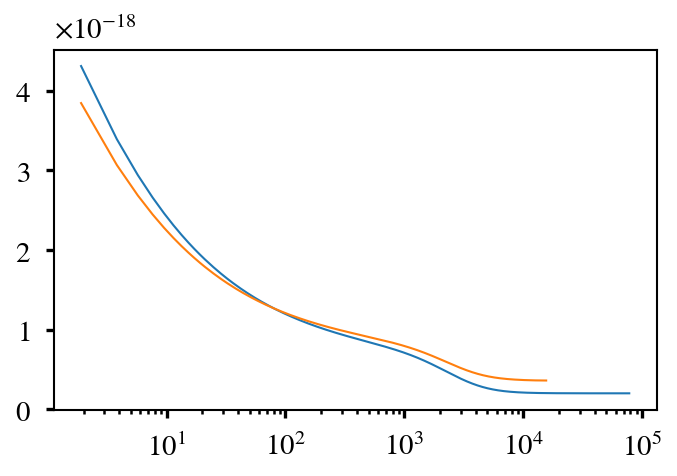

In [14]:
fig, ax = plt.subplots()
ax.set_xscale('log')
#ax.set_yscale('log')
ax.plot(n_to_f * n1, S1)
ax.plot(n_to_f * n1_wad, S1_wad)
#ax.set_xlim(0, n_to_f * n_nyquist)
#ax.set_ylim(1, 4)